# LSTM_Stock_Prediction


給定 2010 ~ 2016 紐約股市的資料：

1. `stt.csv`：State Street Corp (STT) 的資料。
2. `all.csv`：STT 以外其他公司的資料。

csv 中每一行有以下欄位：

1. `date`：日期
2. `symbol`: 公司
3. `open`：開盤價
4. `close`：收盤價
5. `low`：低點
6. `hight`：高點
7. `volume`：交易量

作業如下：

1. 使用 STT 前 15 天的資料來預測第 16 天的交易量(30%)
2. 使用所有跟 STT 同領域的公司前 15 天的資料來預測 STT 第 16 天的收盤價(30%)
3. 使用整個股市的資料前 30 天的資料來預測第 31 天的開盤價(40%)


### 以下範例程式使用STT過去15天的`open`、`close`、`low`和`volume`（without  `high`），來預測STT第16天的最高價（`high`）。

## Task:

1. Use a RNN/LSTM.
2. Plot the loss curve.
3. Report the $MSE$ between your predictions and groundtruths. (both train and valid set)

$$
MSE = \frac{1}{N} \sum_1^N (p_i - q_i)^2
$$
4. Plot the prediction vs groundtruth. (both train and valid set)


where $N$ is number of days and $p_i, q_i$ are the prediction and groudtruth on day $i$ respectively.


## Download Data and Import Libraries

In [1]:
from pathlib import Path
from torchvision.datasets.utils import download_file_from_google_drive

csv_path_stt = Path('./stt.csv')
csv_path_all = Path('./all.csv')

if not csv_path_stt.exists():
    download_file_from_google_drive('1zY26f3Ie5c7Vt9R0wHRz9hGldOsizV4b', '.', csv_path_stt)
if not csv_path_all.exists():
    download_file_from_google_drive('1KtyafQZRtx3FOWpFEe-keoeiVTb2y7Fu', '.', csv_path_all)

Downloading...
From: https://drive.google.com/uc?id=1zY26f3Ie5c7Vt9R0wHRz9hGldOsizV4b
To: /content/stt.csv
100%|██████████| 112k/112k [00:00<00:00, 28.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KtyafQZRtx3FOWpFEe-keoeiVTb2y7Fu
To: /content/all.csv
100%|██████████| 54.5M/54.5M [00:00<00:00, 73.3MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from sklearn.preprocessing import StandardScaler

In [3]:
df_stt = pd.read_csv(csv_path_stt)      # a DataFrame object
df_stt = df_stt.sort_values(by='date')  # csv are not guarenteed to be ordered by date
df_stt.head(10)

,date,symbol,open,close,low,high,volume
0,2010-01-04,STT,43.810001,44.459999,43.549999,44.779999,3440300.0
1,2010-01-05,STT,44.520000,44.549999,44.020000,45.000000,3992500.0
2,2010-01-06,STT,44.400002,43.810001,43.650002,44.669998,4062100.0
3,2010-01-07,STT,44.349998,44.599998,43.980000,44.860001,5273100.0
4,2010-01-08,STT,44.759998,45.509998,44.389999,45.880001,6038000.0
5,2010-01-11,STT,45.889999,44.360001,44.209999,46.099998,4260000.0
6,2010-01-12,STT,43.910000,44.200001,43.910000,44.849998,3432600.0
7,2010-01-13,STT,44.500000,44.610001,43.650002,44.770000,2741000.0
8,2010-01-14,STT,44.330002,43.790001,43.189999,44.419998,4268500.0
9,2010-01-15,STT,43.520000,42.669998,42.520000,44.099998,6887100.0


In [4]:
df_all = pd.read_csv(csv_path_all)      # a DataFrame object
df_all_stock = df_all[df_all['symbol'] == 'ALL']
df_all_stock = df_all_stock.sort_values(by='date')  # csv are not guarenteed to be ordered by date
df_all_stock.head(10)

,date,symbol,open,close,low,high,volume
276,2010-01-04,ALL,30.360001,30.410000,30.090000,30.510000,2631000.0
742,2010-01-05,ALL,30.480000,30.910000,30.139999,30.969999,5342100.0
1209,2010-01-06,ALL,30.900000,30.920000,30.690001,30.980000,3399500.0
1676,2010-01-07,ALL,30.850000,31.080000,30.610001,31.160000,3694900.0
2143,2010-01-08,ALL,30.889999,31.209999,30.790001,31.290001,2806800.0
2610,2010-01-11,ALL,31.340000,31.209999,31.040001,31.440001,2168200.0
3077,2010-01-12,ALL,31.440001,31.180000,31.100000,31.730000,5354300.0
3544,2010-01-13,ALL,31.190001,31.459999,31.190001,31.680000,3517200.0
4011,2010-01-14,ALL,31.350000,31.639999,31.049999,31.730000,3368900.0
4478,2010-01-15,ALL,31.559999,30.910000,30.680000,31.559999,4696600.0


### Train/Valid Split and Feature Normalization

We split first 85% of the entries to be training data, and last 15% to be validation data.
The pivot date is 2015-12-15, i.e., entries after 2015-12-15 (included) is valid data.


Note that scale of the features (`open`, `close`, `low`, `high`, `volume`) are different to each other. In practice, we normalize each features to better train our model. If we do so, the model will suffer gradient vanishment/exploding.

To normalize data, common techniques are:

1. Standard Scaler: $x_{new} = (x - mean) / std$
2. Minmax Scaler: $x_{new} = (x - x_{min}) / (x_{max} - x_{min})$

Both are implemented in `sklearn`. In this code, we use the first one.

**Be careful that when normalizing data, we can use only training data to compute the statistics. Using validation/testing data is not allowed.**


In some cases, we need to obtain original values from normalized features, we can do it using the standard scaler `std` used for normalization.

```python
raw_open = normalize_open* std.scale_[0] + std.mean_[0]
raw_close = normalized_close * std.scale_[1] + std.mean_[1]
raw_low = normalized_low * std.scale_[2] + std.mean_[2]
raw_high = normalized_low * std.scale_[3] + std.mean_[3]
raw_volume = normalized_low * std.scale_[4] + std.mean_[4]
```

In [5]:
pivot = round(0.85 * len(df_all_stock))
print('pivot:', df_stt.loc[pivot, 'date'])

df_train = df_all_stock[:pivot].copy()    # DataFrame
df_valid = df_all_stock[pivot:].copy()    # DataFrame

FEATURES = ['open', 'close', 'low', 'high', 'volume']
std = StandardScaler().fit(df_train[FEATURES])
df_train[FEATURES] = std.transform(df_train[FEATURES])
df_valid[FEATURES] = std.transform(df_valid[FEATURES])

df_train.head(10)

pivot: 2015-12-15


,date,symbol,open,close,low,high,volume
276,2010-01-04,ALL,-0.981951,-0.979263,-0.979912,-0.991450,-0.574703
742,2010-01-05,ALL,-0.973789,-0.945273,-0.976505,-0.960279,0.957769
1209,2010-01-06,ALL,-0.945225,-0.944593,-0.939025,-0.959601,-0.140302
1676,2010-01-07,ALL,-0.948626,-0.933716,-0.944477,-0.947403,0.026675
2143,2010-01-08,ALL,-0.945906,-0.924879,-0.932211,-0.938594,-0.475331
2610,2010-01-11,ALL,-0.915301,-0.924879,-0.915175,-0.928429,-0.836305
3077,2010-01-12,ALL,-0.908500,-0.926918,-0.911086,-0.908777,0.964665
3544,2010-01-13,ALL,-0.925503,-0.907883,-0.904953,-0.912165,-0.073771
4011,2010-01-14,ALL,-0.914621,-0.895647,-0.914493,-0.908777,-0.157599
4478,2010-01-15,ALL,-0.900339,-0.945273,-0.939707,-0.920297,0.592894


# Dataset

To predict the stock on day 16 based on day 1 ~ day 15 features, we expect each sample contains:

1. `feature`: the features of day 1 ~ 15. Each day has 4 features, thus the shape is `[15, 4]`.
2. `target`: the target we are predicting. In this case, it's the `high` of day 16, thus `target` is a shaped `[1]`.

Therefore we are performing a *sliding window*-like operation on the given dataframe.

In [6]:
class CompanyStockData(Dataset):
    def __init__(self, dataframe, window=10):
        super().__init__()
        self.df = dataframe
        self.window = window

    def __len__(self):
        return len(self.df) - self.window

    def __getitem__(self, idx):
        window_s = idx
        window_t = idx + self.window
        feature = self.df.iloc[window_s:window_t - 1]                            # Retrieve entries [window_s, window_t - 1], DataFrame
        feature = feature[['high', 'close', 'low', 'volume']].values                    # Retrieve the wanted features. `.values` make it ndarray
        feature = torch.from_numpy(feature).float()                               # Converty ndarray to tensor
        target = self.df.iloc[window_t - 1]                                 # The entry on the next day
        target = target['open'].item()                                      # Make it python scalar
        target = torch.tensor([target]).float()                               # Make it tensor
        return feature, target


WINDOW = 31
train_set = CompanyStockData(df_train, window=WINDOW)
valid_set = CompanyStockData(df_valid, window=WINDOW)
print('#train:', len(train_set))
print('#valid:', len(valid_set))

feature, target = valid_set[100]
print(feature)
print(target)

#train: 1467
#valid: 233
tensor([[ 1.5491,  1.5748,  1.5592, -0.7907],
        [ 1.5470,  1.5320,  1.5571, -0.8993],
        [ 1.5335,  1.5449,  1.5408, -0.6390],
        [ 1.5342,  1.5340,  1.5544, -1.0806],
        [ 1.5348,  1.5456,  1.5442, -0.9202],
        [ 1.5294,  1.5150,  1.5278, -0.9227],
        [ 1.5213,  1.5326,  1.5190, -0.6874],
        [ 1.4982,  1.4973,  1.5074, -0.8405],
        [ 1.5294,  1.5184,  1.5326, -0.9941],
        [ 1.4955,  1.5000,  1.5135, -1.3094],
        [ 1.5321,  1.5381,  1.5346, -1.0218],
        [ 1.5375,  1.5272,  1.5496, -1.0922],
        [ 1.5206,  1.5428,  1.5455, -1.3667],
        [ 1.5403,  1.5544,  1.5667, -1.5872],
        [ 1.5464,  1.5428,  1.5469, -0.0527],
        [ 1.5152,  1.5381,  1.5128, -1.2149],
        [ 1.5111,  1.5381,  1.5428, -1.4101],
        [ 1.5294,  1.5374,  1.5108, -1.1443],
        [ 1.5504,  1.5503,  1.5639, -0.9542],
        [ 1.5409,  1.5374,  1.5571, -1.2230],
        [ 1.5409,  1.5544,  1.5428, -1.1318],
        [

# Model

We implements following model:



In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_layers=1, num_classes=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True
        )
        self.regressor = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = self.regressor(x[:, -1])        # We only takes last timestamps output of lstm
        return x

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=8,
    num_workers=4,
)
valid_loader = DataLoader(
    valid_set,
    shuffle=False,
    batch_size=8,
    num_workers=4,
)

feature_b, target_b = next(iter(valid_loader))
print(feature_b.shape)  # [N, 15, 4]
print(target_b.shape)   # [N, 1]

model = LSTM(input_size=4, hidden_size=32, num_classes=1)
output_b = model(feature_b)
print(output_b.shape)   # [N, 1]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([8, 30, 4])
torch.Size([8, 1])
torch.Size([8, 1])


Some other RNN model you can try:

In [8]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size=1, num_layers=1, num_classes=1):
        super().__init__()

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

# Training

Train the model in standard way and record losses every epoch.

In [9]:
device = 'cuda'
model = LSTM(input_size=4, hidden_size=32, num_layers=1, num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = {
    'train_loss': [],
    'valid_loss': [],
}

for epoch in tqdm(range(50)):
    # Train
    losses = []
    model.train()
    for feature_b, target_b in iter(train_loader):
        feature_b = feature_b.to(device)
        target_b = target_b.to(device)

        optimizer.zero_grad()
        predict_b = model(feature_b)
        loss = criterion(predict_b, target_b)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    train_loss = sum(losses) / len(losses)

    # Valid
    losses = []
    model.eval()
    for feature_b, target_b in iter(valid_loader):
        feature_b = feature_b.to(device)
        target_b = target_b.to(device)
        predict_b = model(feature_b)
        loss = criterion(predict_b, target_b)
        losses.append(loss.item())
    valid_loss = sum(losses) / len(losses)

    # Logging
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    print('Epoch {:03d}: {:.6f}, {:.6f}'.format(
        epoch, train_loss, valid_loss
    ))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 000: 0.137815, 0.009230
Epoch 001: 0.003722, 0.004425
Epoch 002: 0.002574, 0.004517
Epoch 003: 0.002164, 0.004450
Epoch 004: 0.002056, 0.004516
Epoch 005: 0.001827, 0.005676
Epoch 006: 0.001824, 0.002268
Epoch 007: 0.001689, 0.002300
Epoch 008: 0.001553, 0.002338
Epoch 009: 0.001643, 0.002290
Epoch 010: 0.001411, 0.001999
Epoch 011: 0.001419, 0.001714
Epoch 012: 0.001313, 0.001567
Epoch 013: 0.001252, 0.002586
Epoch 014: 0.001181, 0.002025
Epoch 015: 0.001215, 0.001440
Epoch 016: 0.001216, 0.001384
Epoch 017: 0.001117, 0.001652
Epoch 018: 0.001070, 0.002186
Epoch 019: 0.001036, 0.001189
Epoch 020: 0.000980, 0.004067
Epoch 021: 0.001048, 0.002161
Epoch 022: 0.000962, 0.001248
Epoch 023: 0.001074, 0.001063
Epoch 024: 0.000909, 0.001353
Epoch 025: 0.000876, 0.001476
Epoch 026: 0.000876, 0.002581
Epoch 027: 0.000860, 0.000972
Epoch 028: 0.000860, 0.001669
Epoch 029: 0.000739, 0.000940
Epoch 030: 0.000785, 0.001012
Epoch 031: 0.000753, 0.000998
Epoch 032: 0.000759, 0.001499
Epoch 033:

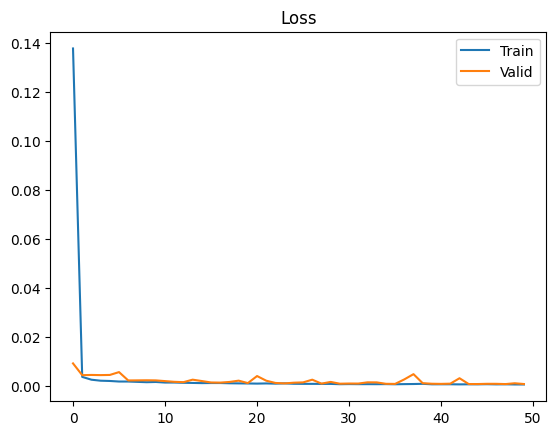

In [10]:
fig, ax = plt.subplots()
ax.plot(history['train_loss'], label='Train')
ax.plot(history['valid_loss'], label='Valid')
ax.set_title('Loss')
ax.legend()
plt.show()

## Evaluation



  0%|          | 0/46 [00:00<?, ?it/s]

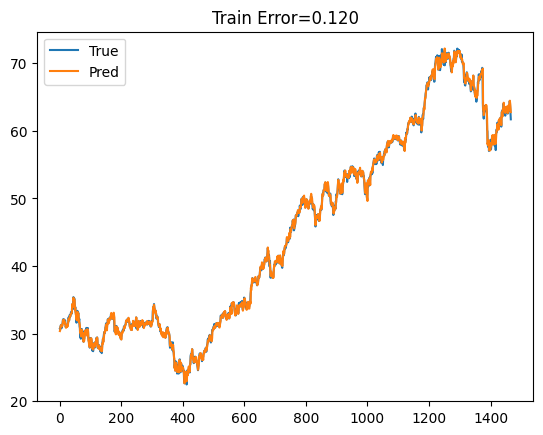

  0%|          | 0/8 [00:00<?, ?it/s]

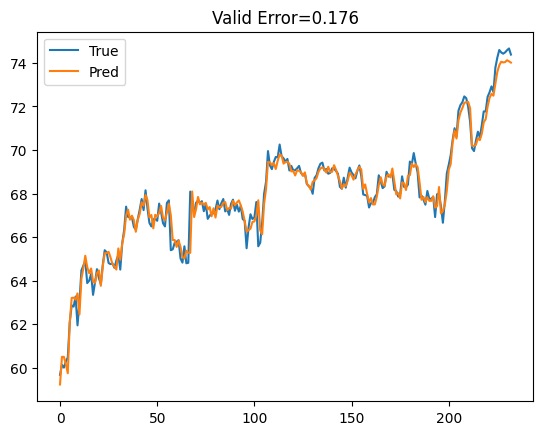

In [11]:
@torch.no_grad()
def evaluate(dataset):
    model.eval()
    preds = []
    trues = []
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
    for feature_b, target_b in tqdm(iter(loader)):
        predict_b = model(feature_b.to(device)).to('cpu')
        preds.extend(predict_b)
        trues.extend(target_b)
    preds = torch.stack(preds).numpy() # [N]
    trues = torch.stack(trues).numpy() # [N]
    return preds, trues


preds, trues = evaluate(train_set)
preds = preds * std.scale_[0] + std.mean_[0]
trues = trues * std.scale_[0] + std.mean_[0]
error = ((preds - trues) ** 2).mean()
fig, ax = plt.subplots()
ax.plot(trues, label='True')
ax.plot(preds, label='Pred')
ax.set_title(f'Train Error={error:.3f}')
ax.legend()
plt.show()

preds, trues = evaluate(valid_set)
preds = preds * std.scale_[0] + std.mean_[0]
trues = trues * std.scale_[0] + std.mean_[0]
error = ((preds - trues) ** 2).mean()
fig, ax = plt.subplots()
ax.plot(trues, label='True')
ax.plot(preds, label='Pred')
ax.set_title(f'Valid Error={error:.3f}')
ax.legend()
plt.show()

## Useful DataFrame methods

1. Use `df.values` to get the underlying ndarray, and use `ndarray` operations.
2. **Use Excel, by hand or other tools you want to calculate the values.**



In [12]:
df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market

df_ual = df_all[df_all['symbol'] == 'UAL']              # select entries that has symbol 'UAL'
# df_ual = df_all[df_all['symbol'].isin(['UAL', 'WU'])] # another way, but can select multiple companies
df_ual = df_ual.reset_index(drop=True)                  # Reset the index to 0, 1, ..., 1761

print(df_ual)

df_ual = df_ual.drop(columns=['symbol', 'date'])        # drop symbol & date columns
data_ual = df_ual.values                                # get its underlying ndarray

print(data_ual.shape)
print(data_ual[:10])

            date symbol       open      close        low       high  \
0     2010-01-04    UAL  12.990000  12.800000  12.530000  13.110000   
1     2010-01-05    UAL  12.870000  13.910000  12.870000  14.100000   
2     2010-01-06    UAL  13.740000  13.270000  13.130000  13.990000   
3     2010-01-07    UAL  13.200000  13.550000  13.200000  13.950000   
4     2010-01-08    UAL  13.560000  13.330000  13.130000  13.860000   
...          ...    ...        ...        ...        ...        ...   
1757  2016-12-23    UAL  74.400002  74.790001  74.129997  74.830002   
1758  2016-12-27    UAL  74.779999  74.669998  74.500000  75.220001   
1759  2016-12-28    UAL  75.000000  73.529999  73.349998  75.180000   
1760  2016-12-29    UAL  73.529999  73.279999  72.930000  74.190002   
1761  2016-12-30    UAL  73.430000  72.879997  72.370003  73.430000   

          volume  
0      8785900.0  
1     23646300.0  
2     15398700.0  
3     10177000.0  
4      5896400.0  
...          ...  
1757   1616800

In [13]:
df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market
df_all = df_all.drop(columns=['date'])

for symbol, group in df_all.groupby('symbol'):          # iterate different companies. group is a DataFrame that is subset of df_all
    print('symbol:', symbol, 'shape:', group.shape)
    print(group.sample(3))                              # print random 3 entries
    group = group.drop(columns=['symbol'])              # drop symbol columns
    print('mean:', group.mean(axis=0).values)           # compute mean of rest columns respectively
    print('-' * 10)

symbol: A shape: (1762, 6)
       symbol       open      close        low       high     volume
442733      A  36.902717  37.074391  36.795421  37.288982  4005400.0
37611       A  26.416310  26.630901  26.366237  26.752504  3237300.0
580593      A  40.389999  41.369999  40.259998  41.410000  2968300.0
mean: [3.40652898e+01 3.40802207e+01 3.37141014e+01 3.44148416e+01
 3.92758910e+06]
----------
symbol: AAL shape: (1762, 6)
       symbol       open      close        low       high      volume
21733     AAL   7.920000   7.840000   7.650000   7.940000   7152300.0
664277    AAL  42.040001  42.060001  41.290001  42.459999  12701500.0
637630    AAL  52.680000  51.869999  51.700001  52.680000   9843400.0
mean: [2.38751078e+01 2.38737684e+01 2.34664529e+01 2.42839331e+01
 9.35403802e+06]
----------
symbol: AAP shape: (1762, 6)
       symbol       open      close        low       high     volume
267281    AAP  89.610001  89.820000  88.900002  89.849998   713100.0
378189    AAP  79.089996  80.69

In [14]:
df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market
df_all = df_all.drop(columns=['date'])

groups = [] # Select those companies that has 1762 entries and symbol is started with 'Y'
for symbol, group in df_all.groupby('symbol'):          # iterate different companies. group is a DataFrame that is subset of df_all
    if len(group) == 1762 and symbol.startswith('Y'):
        groups.append(group)
df = pd.concat(groups)                                  # Concatenate those groups
df = df.reset_index(drop=True)                          # Reset the index to 0, 1, ..., 1761

print(df.shape)
print(df['symbol'].unique())                            # Companies

(3524, 6)
['YHOO' 'YUM']
